# Representation Learning


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

In [8]:
#X = df.groupby("RecordID").last(numeric_only=True).reset_index()
#X = X.drop(columns=["RecordID"])
#X = X[sorted(X.columns)]

In [11]:
# Retrieving the label vector
#y_df = pd.read_parquet('processed-data/processed-outcomes-a.parquet')
#y = y_df["In-hospital_death"].to_numpy().flatten()

554
4000


In [33]:
# Load data
# Training set (Set A)
df_train = pd.read_parquet('final-data/final-set-a.parquet')
df_train = df_train.fillna(0)  # Replace NaN with 0 if any remain

# Validation set (Set B) - for hyperparameter tuning
df_val = pd.read_parquet('final-data/final-set-b.parquet')
df_val = df_val.fillna(0)
if 'ICUType' in df_val.columns:
        print("Removing ICUType column as requested")
        df_val = df_val.drop(columns=['ICUType'])

Removing ICUType column as requested


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196000 entries, 0 to 195999
Data columns (total 42 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         196000 non-null  int64  
 1   Age          196000 non-null  float64
 2   BUN          196000 non-null  float64
 3   Creatinine   196000 non-null  float64
 4   GCS          196000 non-null  float64
 5   Gender       196000 non-null  float64
 6   Glucose      196000 non-null  float64
 7   HCO3         196000 non-null  float64
 8   HCT          196000 non-null  float64
 9   HR           196000 non-null  float64
 10  Height       196000 non-null  float64
 11  K            196000 non-null  float64
 12  Mg           196000 non-null  float64
 13  NIDiasABP    196000 non-null  float64
 14  NIMAP        196000 non-null  float64
 15  NISysABP     196000 non-null  float64
 16  Na           196000 non-null  float64
 17  Platelets    196000 non-null  float64
 18  RecordID     196000 non-

### Q3.1 Pretraining and Linear Probes (4 pts)

To begin with, we pre-train an autoencoder consisting of the classical encoder-decoder architecture.

In [36]:
def prepare_sequence_data(df):
    """
    Convert dataframe to sequence format grouped by RecordID.
    Returns a dictionary mapping RecordID to the sequential ICU data.
    """
    patient_sequences = {}
    
    for record_id, group in df.groupby('RecordID'):
        # Sort by timestamp to ensure temporal order
        group = group.sort_values('Time')
        
        # Get features - excluding RecordID and Time
        features = group.drop(['RecordID', 'Time'], axis=1).values
        
        patient_sequences[record_id] = features
    
    return patient_sequences

In [37]:
def create_tensor_dataset(patient_sequences):
    """
    Create a PyTorch TensorDataset from patient sequences.
    """
    sequences = []
    record_ids = []
    
    for record_id, sequence in patient_sequences.items():
        sequences.append(sequence)
        record_ids.append(record_id)
    
    # Convert to tensors
    sequences_tensor = torch.FloatTensor(np.array(sequences))
    record_ids_tensor = torch.LongTensor(np.array(record_ids))
    
    return TensorDataset(sequences_tensor, record_ids_tensor)

In [38]:
# Prepare data
train_sequences = prepare_sequence_data(df_train)
val_sequences = prepare_sequence_data(df_val)

# Create datasets, dataloaders
train_dataset = create_tensor_dataset(train_sequences)
val_dataset = create_tensor_dataset(val_sequences)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Note that the patient's time series data consisted of 49 time stemps * 40 features, so 1960-dimensional data, which we represent in a latent space of dimension 64.

In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, embedding_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embedding_dim)  # *2 for bidirectional
    
    def forward(self, x):
        # x shape: [batch_size, seq_length, features]
        output, (hidden, _) = self.lstm(x)
        
        # For bidirectional LSTM, concatenate the last hidden states from both directions
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        # Project to embedding dimension
        embedding = self.fc(hidden_cat)
        return embedding

In [40]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, output_dim=41):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, embedding, seq_length):
        # embedding shape: [batch_size, embedding_dim]
        # Transform embedding to hidden state
        hidden = self.fc(embedding).unsqueeze(0)  # [1, batch_size, hidden_dim]
        
        # Initialize cell state
        cell = torch.zeros_like(hidden)
        
        # Repeat the hidden state as input for each time step
        decoder_input = hidden.permute(1, 0, 2).repeat(1, seq_length, 1)
        
        # Pass through LSTM
        output, _ = self.lstm(decoder_input, (hidden, cell))
        
        # Project to output dimension
        reconstructed = self.output_layer(output)
        return reconstructed

In [41]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, embedding_dim=64):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, input_dim)
    
    def forward(self, x):
        # Get sequence length
        seq_length = x.size(1)
        
        # Encode
        embedding = self.encoder(x)
        
        # Decode
        reconstructed = self.decoder(embedding, seq_length)
        
        return reconstructed, embedding

In [42]:
# Verify features dimension
input_dim= train_dataset[0][0].shape[1]  
print("Features dimension train: ", input_dim)

input_dim_val = val_dataset[0][0].shape[1]  
print("Features dimension val: ", input_dim_val)

Features dimension train:  40
Features dimension val:  40


100%|██████████| 125/125 [00:05<00:00, 22.36it/s]


Epoch 1/50, Train Loss: 0.465713, Val Loss: 0.822971


100%|██████████| 125/125 [00:05<00:00, 23.48it/s]


Epoch 2/50, Train Loss: 0.349462, Val Loss: 0.775757


100%|██████████| 125/125 [00:05<00:00, 21.72it/s]


Epoch 3/50, Train Loss: 0.307817, Val Loss: 0.743548


100%|██████████| 125/125 [00:05<00:00, 23.27it/s]


Epoch 4/50, Train Loss: 0.282714, Val Loss: 0.724061


100%|██████████| 125/125 [00:05<00:00, 23.13it/s]


Epoch 5/50, Train Loss: 0.262321, Val Loss: 0.704911


100%|██████████| 125/125 [00:05<00:00, 23.47it/s]


Epoch 6/50, Train Loss: 0.245811, Val Loss: 0.687021


100%|██████████| 125/125 [00:05<00:00, 23.11it/s]


Epoch 7/50, Train Loss: 0.235366, Val Loss: 0.676467


100%|██████████| 125/125 [00:05<00:00, 23.03it/s]


Epoch 8/50, Train Loss: 0.225371, Val Loss: 0.660475


100%|██████████| 125/125 [00:05<00:00, 22.97it/s]


Epoch 9/50, Train Loss: 0.216869, Val Loss: 0.651479


100%|██████████| 125/125 [00:05<00:00, 23.22it/s]


Epoch 10/50, Train Loss: 0.211383, Val Loss: 0.641311


100%|██████████| 125/125 [00:05<00:00, 22.95it/s]


Epoch 11/50, Train Loss: 0.206182, Val Loss: 0.637795


100%|██████████| 125/125 [00:05<00:00, 24.04it/s]


Epoch 12/50, Train Loss: 0.202087, Val Loss: 0.631041


100%|██████████| 125/125 [00:05<00:00, 23.60it/s]


Epoch 13/50, Train Loss: 0.198602, Val Loss: 0.623459


100%|██████████| 125/125 [00:05<00:00, 23.99it/s]


Epoch 14/50, Train Loss: 0.194645, Val Loss: 0.621658


100%|██████████| 125/125 [00:05<00:00, 23.57it/s]


Epoch 15/50, Train Loss: 0.189980, Val Loss: 0.620054


100%|██████████| 125/125 [00:05<00:00, 23.59it/s]


Epoch 16/50, Train Loss: 0.187439, Val Loss: 0.612068


100%|██████████| 125/125 [00:05<00:00, 23.66it/s]


Epoch 17/50, Train Loss: 0.183919, Val Loss: 0.611805


100%|██████████| 125/125 [00:05<00:00, 23.72it/s]


Epoch 18/50, Train Loss: 0.181402, Val Loss: 0.607898


100%|██████████| 125/125 [00:05<00:00, 22.20it/s]


Epoch 19/50, Train Loss: 0.180143, Val Loss: 0.606732


100%|██████████| 125/125 [00:05<00:00, 23.30it/s]


Epoch 20/50, Train Loss: 0.177384, Val Loss: 0.600815


100%|██████████| 125/125 [00:05<00:00, 23.86it/s]


Epoch 21/50, Train Loss: 0.174277, Val Loss: 0.598469


100%|██████████| 125/125 [00:05<00:00, 23.78it/s]


Epoch 22/50, Train Loss: 0.172587, Val Loss: 0.597921


100%|██████████| 125/125 [00:05<00:00, 23.85it/s]


Epoch 23/50, Train Loss: 0.171049, Val Loss: 0.599746


100%|██████████| 125/125 [00:05<00:00, 23.61it/s]


Epoch 24/50, Train Loss: 0.171066, Val Loss: 0.600489


100%|██████████| 125/125 [00:05<00:00, 23.70it/s]


Epoch 25/50, Train Loss: 0.171149, Val Loss: 0.594348


100%|██████████| 125/125 [00:05<00:00, 23.89it/s]


Epoch 26/50, Train Loss: 0.164871, Val Loss: 0.592148


100%|██████████| 125/125 [00:05<00:00, 20.89it/s]


Epoch 27/50, Train Loss: 0.162980, Val Loss: 0.589034


100%|██████████| 125/125 [00:05<00:00, 23.28it/s]


Epoch 28/50, Train Loss: 0.163486, Val Loss: 0.587912


100%|██████████| 125/125 [00:05<00:00, 23.08it/s]


Epoch 29/50, Train Loss: 0.164073, Val Loss: 0.591054


100%|██████████| 125/125 [00:05<00:00, 22.89it/s]


Epoch 30/50, Train Loss: 0.161112, Val Loss: 0.584263


100%|██████████| 125/125 [00:05<00:00, 23.06it/s]


Epoch 31/50, Train Loss: 0.156872, Val Loss: 0.588924


100%|██████████| 125/125 [00:05<00:00, 23.39it/s]


Epoch 32/50, Train Loss: 0.155344, Val Loss: 0.585757


100%|██████████| 125/125 [00:05<00:00, 23.35it/s]


Epoch 33/50, Train Loss: 0.153948, Val Loss: 0.585489


100%|██████████| 125/125 [00:05<00:00, 23.41it/s]


Epoch 34/50, Train Loss: 0.168601, Val Loss: 0.591679


100%|██████████| 125/125 [00:05<00:00, 23.25it/s]


Epoch 35/50, Train Loss: 0.158530, Val Loss: 0.581368


100%|██████████| 125/125 [00:05<00:00, 23.21it/s]


Epoch 36/50, Train Loss: 0.153242, Val Loss: 0.579993


100%|██████████| 125/125 [00:05<00:00, 23.30it/s]


Epoch 37/50, Train Loss: 0.152205, Val Loss: 0.577104


100%|██████████| 125/125 [00:05<00:00, 23.20it/s]


Epoch 38/50, Train Loss: 0.152654, Val Loss: 0.587599


100%|██████████| 125/125 [00:05<00:00, 23.10it/s]


Epoch 39/50, Train Loss: 0.150560, Val Loss: 0.578228


100%|██████████| 125/125 [00:05<00:00, 23.32it/s]


Epoch 40/50, Train Loss: 0.151247, Val Loss: 0.577673


100%|██████████| 125/125 [00:05<00:00, 21.79it/s]


Epoch 41/50, Train Loss: 0.147963, Val Loss: 0.581309


100%|██████████| 125/125 [00:05<00:00, 23.87it/s]


Epoch 42/50, Train Loss: 0.148834, Val Loss: 0.575784


100%|██████████| 125/125 [00:05<00:00, 23.87it/s]


Epoch 43/50, Train Loss: 0.145574, Val Loss: 0.574866


100%|██████████| 125/125 [00:05<00:00, 23.78it/s]


Epoch 44/50, Train Loss: 0.143024, Val Loss: 0.576776


100%|██████████| 125/125 [00:05<00:00, 22.43it/s]


Epoch 45/50, Train Loss: 0.144680, Val Loss: 0.577681


100%|██████████| 125/125 [00:05<00:00, 23.86it/s]


Epoch 46/50, Train Loss: 0.143105, Val Loss: 0.583976


100%|██████████| 125/125 [00:05<00:00, 23.78it/s]


Epoch 47/50, Train Loss: 0.143260, Val Loss: 0.578970


100%|██████████| 125/125 [00:05<00:00, 22.03it/s]


Epoch 48/50, Train Loss: 0.143256, Val Loss: 0.578854
Early stopping after 48 epochs


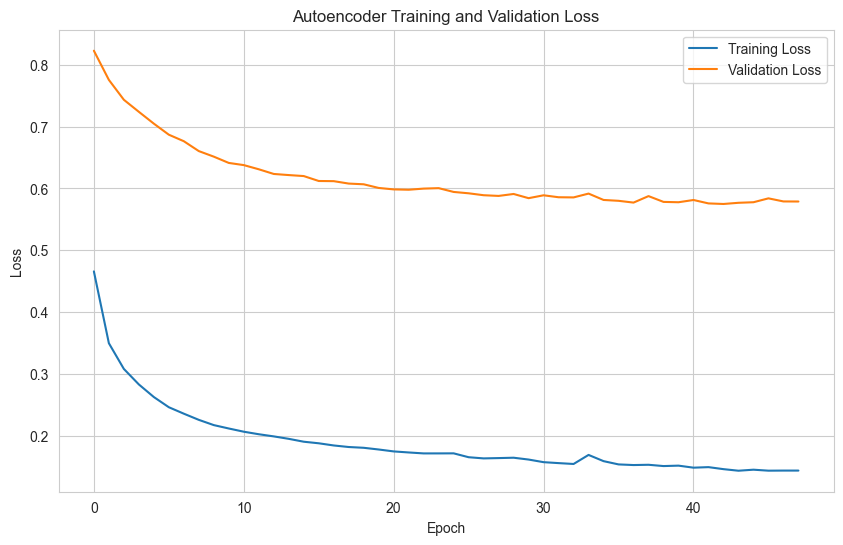

<All keys matched successfully>

In [43]:
# Initialize model and optimization
hidden_dim = 128
embedding_dim = 64
autoencoder = TimeSeriesAutoencoder(input_dim, hidden_dim, embedding_dim)

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('autoencoder_loss.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))

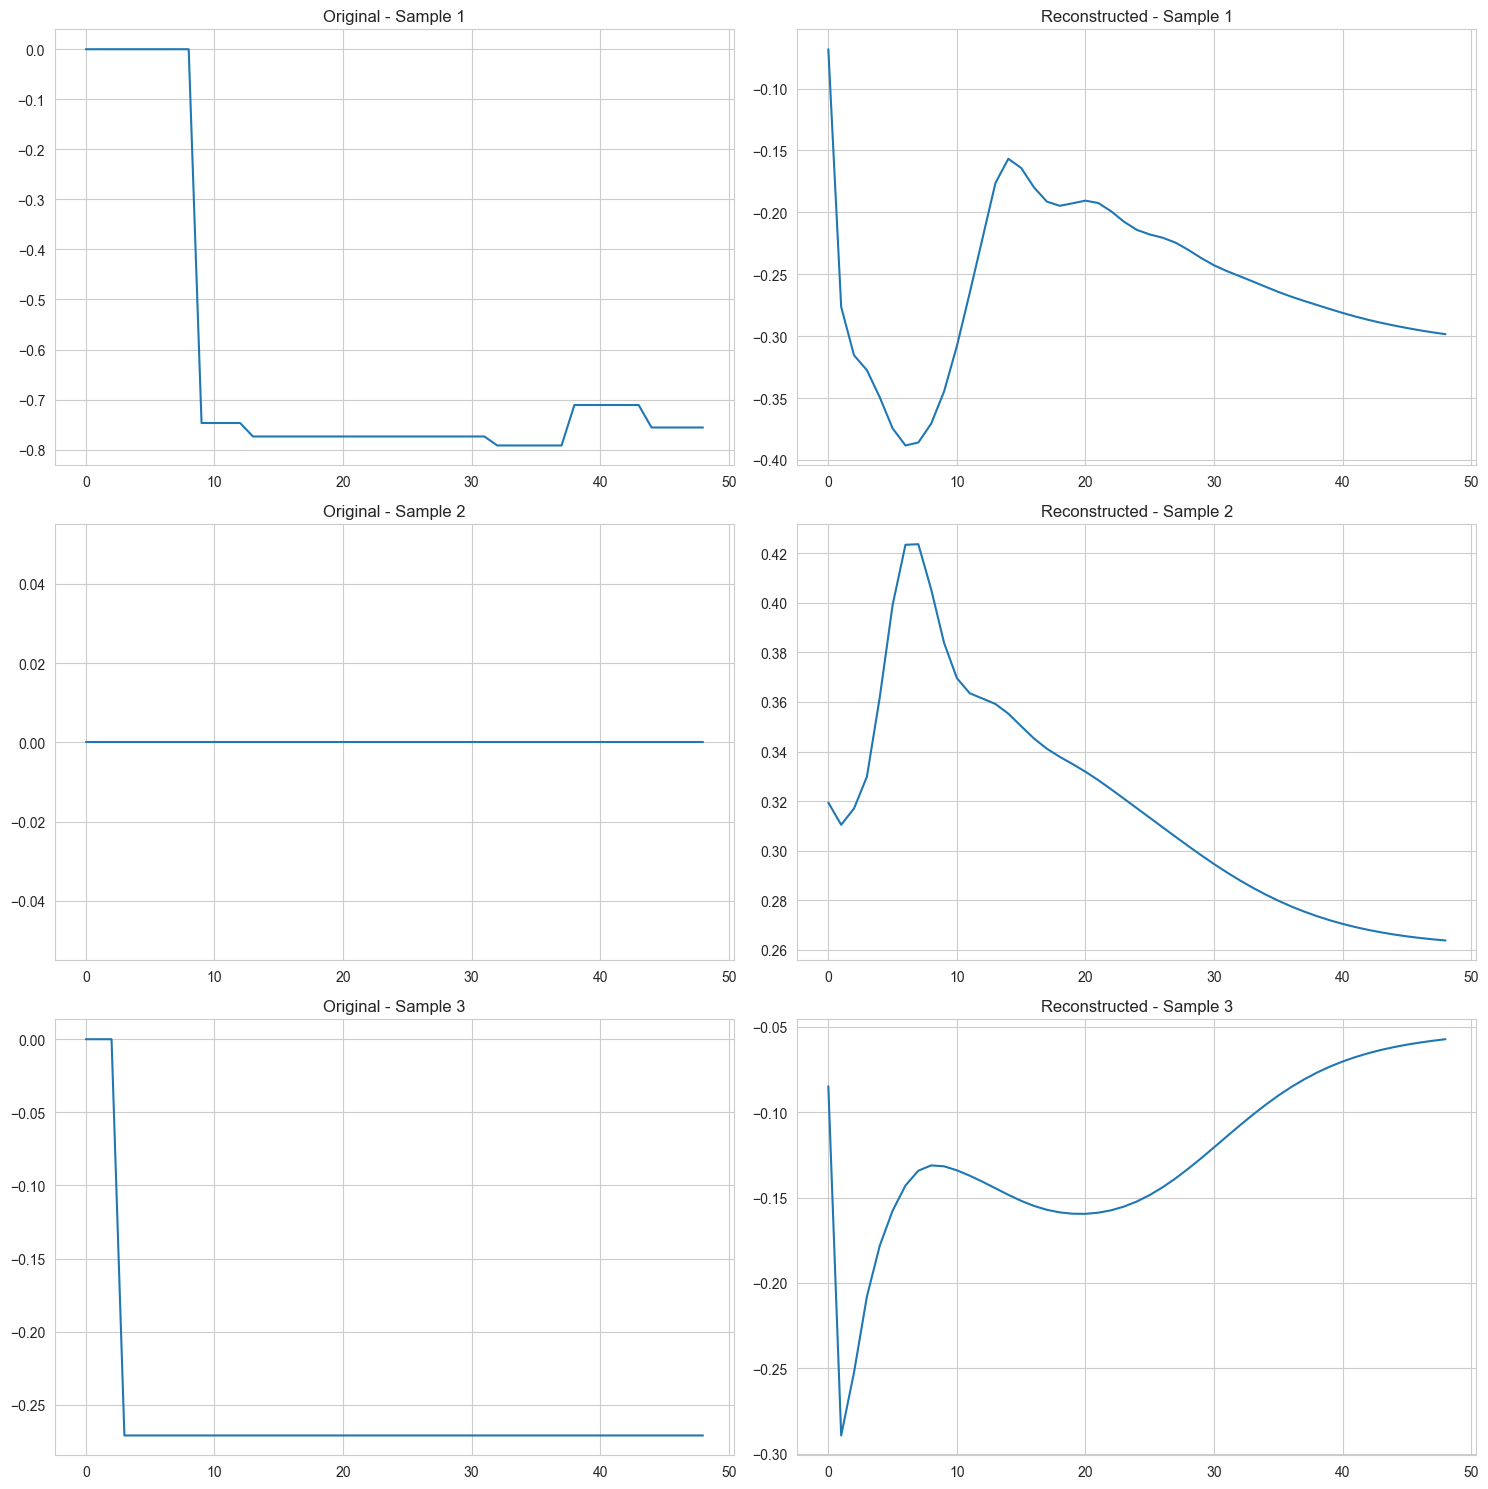

Autoencoder training complete and embeddings generated!


In [44]:
# Function to generate embeddings for all patients
def generate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    record_ids = []
    
    with torch.no_grad():
        for data, ids in dataloader:
            data = data.to(device)
            _, embedding = model(data)
            
            embeddings.append(embedding.cpu().numpy())
            record_ids.extend(ids.numpy())
    
    # Concatenate all embeddings
    embeddings = np.vstack(embeddings)
    
    # Create a dictionary mapping record_id to embedding
    embedding_dict = {record_id: emb for record_id, emb in zip(record_ids, embeddings)}
    
    return embedding_dict

# Generate embeddings
train_embedding_dict = generate_embeddings(autoencoder, train_loader, device)
val_embedding_dict = generate_embeddings(autoencoder, val_loader, device)

# Save embeddings
embedding_df_train = pd.DataFrame.from_dict(train_embedding_dict, orient='index')
embedding_df_train.index.name = 'RecordID'
embedding_df_train.to_csv('train_embeddings.csv')

embedding_df_val = pd.DataFrame.from_dict(val_embedding_dict, orient='index')
embedding_df_val.index.name = 'RecordID'
embedding_df_val.to_csv('val_embeddings.csv')

# Visualize some reconstructions
def visualize_reconstructions(model, dataloader, device, num_samples=3):
    model.eval()
    
    # Get samples
    samples = []
    for data, _ in dataloader:
        samples.append(data[:num_samples])
        break
    
    samples = samples[0].to(device)
    reconstructed, _ = model(samples)
    
    # Convert to numpy for plotting
    samples = samples.cpu().numpy()
    reconstructed = reconstructed.detach().cpu().numpy()
    
    # Plot
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Original
        axes[i, 0].plot(samples[i, :, 0])  # Plot first feature for simplicity
        axes[i, 0].set_title(f'Original - Sample {i+1}')
        
        # Reconstructed
        axes[i, 1].plot(reconstructed[i, :, 0])
        axes[i, 1].set_title(f'Reconstructed - Sample {i+1}')
    
    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()

# Visualize reconstructions
visualize_reconstructions(autoencoder, val_loader, device)

print("Autoencoder training complete and embeddings generated!")

Linear Probe evaluation

In [48]:
# Load outcomes data
outcomes_train = pd.read_parquet('processed-data/processed-outcomes-a.parquet')  
outcomes_val = pd.read_parquet('processed-data/processed-outcomes-b.parquet')    
outcomes_test = pd.read_parquet('processed-data/processed-outcomes-c.parquet')  

# Extract the in-hospital mortality labels
train_labels = outcomes_train.set_index('RecordID')['In-hospital_death']
val_labels = outcomes_val.set_index('RecordID')['In-hospital_death']
test_labels = outcomes_test.set_index('RecordID')['In-hospital_death']

# Prepare data for linear probe
# Merge embeddings with labels
train_data = embedding_df_train.join(train_labels, how='inner')
val_data = embedding_df_val.join(val_labels, how='inner')

# Split features and labels
X_train = train_data.drop('In-hospital_death', axis=1)
y_train = train_data['In-hospital_death']

X_val = val_data.drop('In-hospital_death', axis=1)
y_val = val_data['In-hospital_death']

C=0.001, Validation AuROC: 0.4577, Validation AuPRC: 0.1327
C=0.01, Validation AuROC: 0.4454, Validation AuPRC: 0.1263
C=0.1, Validation AuROC: 0.4316, Validation AuPRC: 0.1213
C=1, Validation AuROC: 0.4301, Validation AuPRC: 0.1206
C=10, Validation AuROC: 0.4285, Validation AuPRC: 0.1206
C=100, Validation AuROC: 0.4268, Validation AuPRC: 0.1206
Best validation AuROC: 0.4577
Removing ICUType column as requested
Test AuROC: 0.5672
Test AuPRC: 0.1944


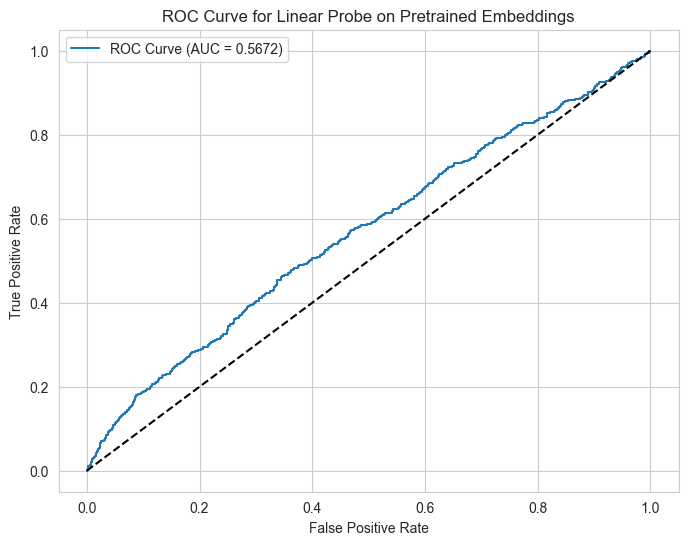

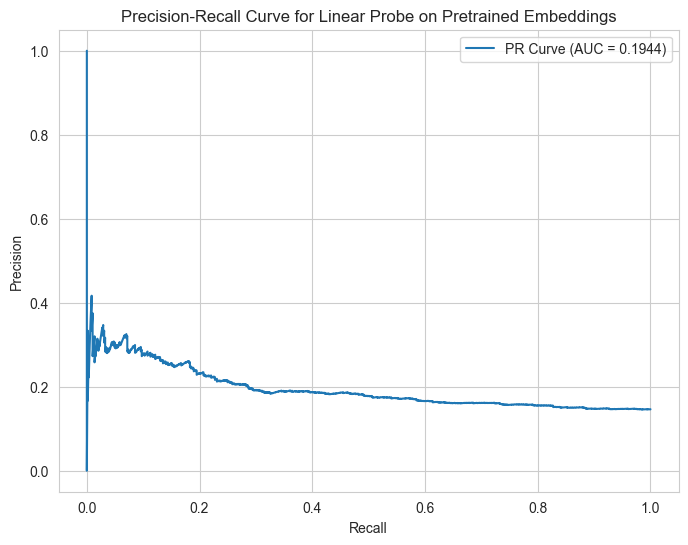

Linear probe evaluation complete!


In [50]:
# Logistic Regression with different regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_val_auc = 0
best_model = None

for C in C_values:
    # Train model
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_auprc = average_precision_score(y_val, val_probs)
    
    print(f"C={C}, Validation AuROC: {val_auc:.4f}, Validation AuPRC: {val_auprc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model

print(f"Best validation AuROC: {best_val_auc:.4f}")

# Now evaluate on test set
# First, load test data
df_test = pd.read_parquet('final-data/final-set-c.parquet')
df_test = df_test.fillna(0)
if 'ICUType' in df_test.columns:
        print("Removing ICUType column as requested")
        df_test = df_test.drop(columns=['ICUType'])

# Prepare test data
test_sequences = prepare_sequence_data(df_test)
test_dataset = create_tensor_dataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate embeddings for test set
test_embedding_dict = generate_embeddings(autoencoder, test_loader, device)
embedding_df_test = pd.DataFrame.from_dict(test_embedding_dict, orient='index')
embedding_df_test.index.name = 'RecordID'

# Merge with labels
test_data = embedding_df_test.join(test_labels, how='inner')
X_test = test_data.drop('In-hospital_death', axis=1)
y_test = test_data['In-hospital_death']

# Make predictions
test_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"Test AuROC: {test_auc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")

# Plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# Plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {test_auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('pr_curve.png')
plt.show()

print("Linear probe evaluation complete!")

### Q3.2 Simulate label scarcity (4 pts)

### Q3.3: Visualising Learned Representations (4 Pts)